# SQuAD Question Answering Chatbot using T5 model

The goal of this notebook is to develop a generative chatbot capable of answering questions based on contexts found in the Stanford Question Answering Dataset (SQuAD). The implementation aimed to fine-tune a transformer based T5 model that effectively understands user queries, retrieves relevant context, and generates accurate answer.
My primary focus is on fine-tuning the T5-base model using the SQuAD v1.1 dataset, which is divided into a training set and a validation set. The ultimate goal is to enhance the chatbot's ability to comprehend complex questions and provide precise answers. Additionally, I aim to develop an interactive user interface within a Jupyter Notebook to facilitate real-time question-answering interactions, ensuring the model's practical applicability in educational and information retrieval settings.

In [1]:
# Import required modules
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import re

## Environment Setup

In [2]:
%%capture

# Set max column width to None to display full text without truncation
pd.set_option('display.max_colwidth', None)

# Check for GPU avilability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check Colab/local setup
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    # Google Colab setup
    print("Running on Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Drive path for datasets
    data_folder_path = '/content/drive/MyDrive/USD/AAI-520-NLPGenAI/FinalProject/stanford/archive/'
    model_check_point_dir = '/content/drive/MyDrive/USD/AAI-520-NLPGenAI/FinalProject/'

    # Install any necessary packages on Colab
    !pip install tqdm
    !pip install sentence_transformers
    !pip install faiss-gpu
    !pip install ipywidgets
    !pip install IPython
    #!pip install tensorboard
    !pip install word2number

else:
    # Local machine setup
    print("Running on local machine")
    # Define the local path to dataset
    data_folder_path = '../stanford/archive/'
    model_check_point_dir = './'

## Pre-processing

The SQuAD dataset is provided in JSON format, which contains detailed structured data including titles, paragraphs, questions, and answers. The task of pre-processing is to parse this JSON data into a DataFrames for both the training and validation datasets. This transformation involves extracting relevant fields such as the context, the question, and the corresponding answer.

In SQuAD dataset structure each context is associated with multiple questions and their corresponding answers. To adapt this structure for training with the T5 model, I take a preprocessing step where I separate each context into individual instances per question-and-answer pair. This means that each row in my DataFrame represents a single pairing of a context, a question derived from that context, and its answer. This approach ensures that each training and validation example is self-contained, with its own context explicitly linked to a specific question and answer, which is essential for the generative capabilities of the T5 model.
Once the data is in DataFrame format, I then convert it into the specific input format required by the T5 model. This involves concatenating the 'question' and 'context' fields into a single string, using a separator such as "context:" and "question:" to clearly mark the contextual and question information. This precise formatting helps the T5 model to better understand where to find and how to generate the answer within the given context.

Following the formatting of the data, the next essential step is to tokenize and embed the data using the T5 tokenizer. This tokenizer adeptly converts the textual data into a numerical format that the T5 model can interpret, handling the mapping of text sequences to their corresponding token IDs, which are integral to the model's vocabulary. It also includes necessary tokens like pad, eos, and bos which are crucial for the model's training and inference processes.

In [3]:
# Load training SQuAD dataset
with open(data_folder_path +"train-v1.1.json", "r") as f:
    train_squad_data = json.load(f)

# Load validation SQuAD dataset
with open(data_folder_path +"dev-v1.1.json", "r") as f:
    validation_squad_data = json.load(f)

In [4]:
train_squad_data["data"][0].keys()

dict_keys(['title', 'paragraphs'])

In [5]:
# Function to parse and extract data from the json file
def parse_data(data):
    articles = []

    for article in data["data"]:
        for paragraph in article["paragraphs"]:
            for qa in paragraph["qas"]:
                question = qa["question"]
                answer = qa["answers"][0]["text"]
                inputs = {"title":article["title"], "context": paragraph["context"], "question": question, "answer": answer}
                articles.append(inputs)

    return articles
# Create a training dataframe
squad_df_train_s = pd.DataFrame(parse_data(train_squad_data))
# Create a valisation dataframe
squad_df_validation_s = pd.DataFrame(parse_data(validation_squad_data))

In [6]:
# TRIM for testing locally
#squad_df_train = squad_df_train_s[:1000]
#squad_df_validation = squad_df_validation_s[:1000]

In [7]:
MAX_CONTEXT_LENGTH = 512

# Combine the dataframe and shuffle
shuffled_df = pd.concat([squad_df_train_s, squad_df_validation_s], axis=0, ignore_index=True).sample(frac=1)
# Remove rows where the length of 'context' is greater than MAX_CONTEXT_LENGTH
shuffled_df_filtered = shuffled_df[shuffled_df['context'].str.split().apply(len) <= MAX_CONTEXT_LENGTH]

print(shuffled_df.shape, shuffled_df_filtered.shape)

# Split the shuffled_df into validation(10%) and train sets
squad_df_train, squad_df_validation = train_test_split(shuffled_df_filtered, test_size=0.10, random_state=42)
squad_df_train = squad_df_train.reset_index(drop=True)
squad_df_validation =squad_df_validation.reset_index(drop=True)

(98169, 4) (98145, 4)


In [8]:
squad_df_validation.shape

(9815, 4)

In [9]:
squad_df_train.shape

(88330, 4)

In [10]:
squad_df_train.head(1)

,title,context,question,answer
0,Middle_Ages,"One of the major developments in the military sphere during the Late Middle Ages was the increased use of infantry and light cavalry. The English also employed longbowmen, but other countries were unable to create similar forces with the same success. Armour continued to advance, spurred by the increasing power of crossbows, and plate armour was developed to protect soldiers from crossbows as well as the hand-held guns that were developed. Pole arms reached new prominence with the development of the Flemish and Swiss infantry armed with pikes and other long spears.",What troops were uniquely successful in English service?,longbowmen


In [11]:
# Convert data to the T5 format by prompting the feature with "context:" and "question:" tags.
def format_data(row):
    input_text = f"question: {row['question']} context: {row['context']}"
    target_text = f"{row['answer']}"
    return pd.Series([input_text, target_text])

tqdm.pandas()  # This enables pandas integration with tqdm

# Apply the function across the DataFrame
train_data_T5Format = squad_df_train.progress_apply(format_data, axis=1)
train_data_T5Format.columns = ['input_text', 'target_text']

validation_data_T5Format = squad_df_validation.progress_apply(format_data, axis=1)
validation_data_T5Format.columns = ['input_text', 'target_text']


100%|██████████| 9815/9815 [00:03<00:00, 3257.86it/s]


## EDA

The EDA involves a detailed examination of the lengths of the context, questions, and answers, represented through histograms. The context length distribution reveals that most contexts range between 100 to 250 words, which informs the tokenization process by helping set appropriate maximum length parameters to avoid truncating vital information. Similarly, the question length distribution indicates that questions are typically concise, generally spanning 10 to 20 words. This insight helps tailor the model to process and understand brief queries efficiently. Moreover, the answer length distribution, predominantly between 1 to 3 words, underscores the necessity for the model to generate precise, concise responses. Additionally, I employ a word cloud visualization to represent the unique topics mentioned in the title. Topics include "United Kingdom," "University of Norte Dame," "Genocide," alongside terms associated with notable figures such as "Beyoncé" and specific subjects like "Antibiotics." This visualization illustrates the broad range of topic covered within the dataset.

In [12]:
squad_df_train['context length'] = squad_df_train['context'].apply(lambda x: len(x.split()))
squad_df_train['question length'] = squad_df_train['question'].apply(lambda x: len(x.split()))
squad_df_train['answer length'] = squad_df_train['answer'].apply(lambda x: len(x.split()))

In [13]:
squad_df_train.head(1)

,title,context,question,answer,context length,question length,answer length
0,Middle_Ages,"One of the major developments in the military sphere during the Late Middle Ages was the increased use of infantry and light cavalry. The English also employed longbowmen, but other countries were unable to create similar forces with the same success. Armour continued to advance, spurred by the increasing power of crossbows, and plate armour was developed to protect soldiers from crossbows as well as the hand-held guns that were developed. Pole arms reached new prominence with the development of the Flemish and Swiss infantry armed with pikes and other long spears.",What troops were uniquely successful in English service?,longbowmen,92,8,1


In [14]:
print("Context length summary:\n\n", squad_df_train['context length'].describe())

Context length summary:

 count    88330.000000
mean       120.096287
std         49.605365
min         20.000000
25%         89.000000
50%        110.000000
75%        142.000000
max        509.000000
Name: context length, dtype: float64


In [15]:
print("Question length summary:\n\n", squad_df_train['question length'].describe())

Question length summary:

 count    88330.000000
mean        10.076293
std          3.560214
min          1.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         40.000000
Name: question length, dtype: float64


In [16]:
print("Answer length summary:\n\n", squad_df_train['answer length'].describe())

Answer length summary:

 count    88330.000000
mean         3.140552
std          3.344372
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         43.000000
Name: answer length, dtype: float64


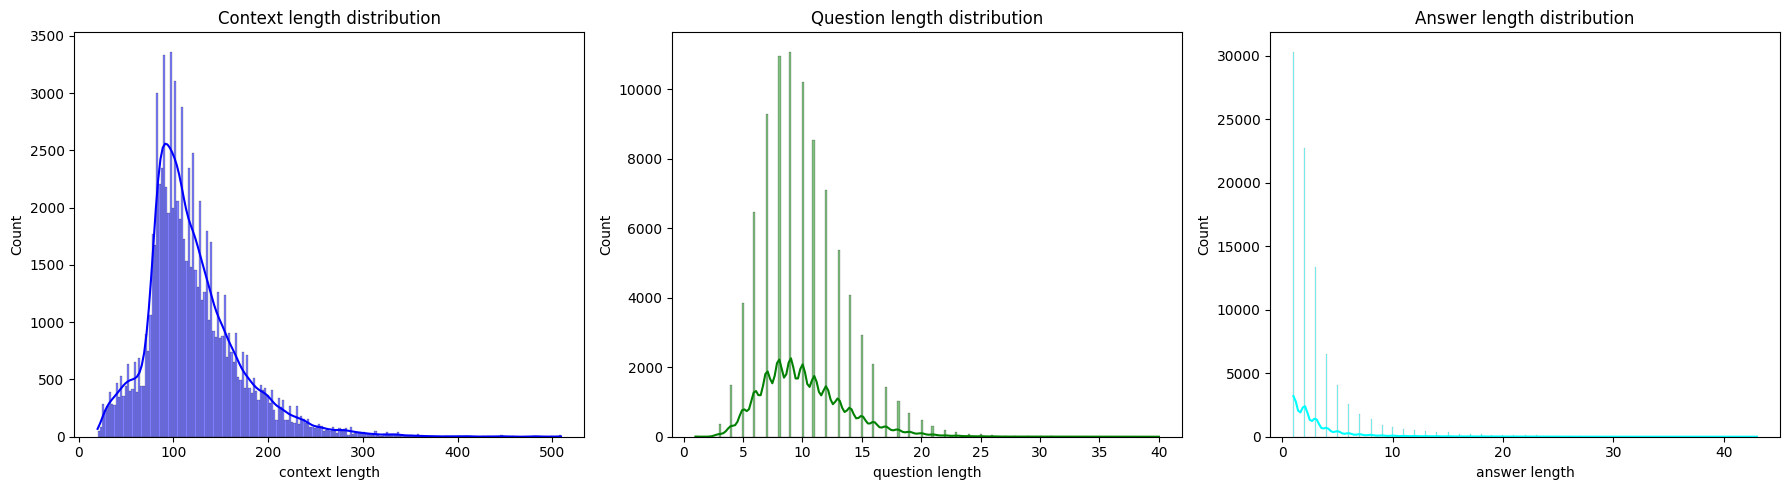

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot histograms
sns.histplot(squad_df_train['context length'], kde=True, color="blue", ax=axes[0])
axes[0].set_title('Context length distribution')

sns.histplot(squad_df_train['question length'], kde=True, color="green", ax=axes[1])
axes[1].set_title('Question length distribution')

sns.histplot(squad_df_train['answer length'], kde=True, color="cyan", ax=axes[2])
axes[2].set_title('Answer length distribution')

# Show the plot
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Answer context overlap')

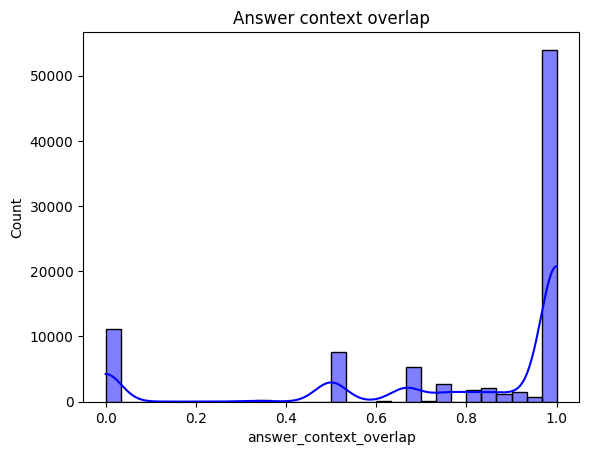

In [18]:
# Analyze the percentage of the answer text that overlaps with the context. In some cases, answers might contain extra information not present in the context, which could lead to inconsistencies in training.
def overlap(context, answer):
    context_tokens = set(context.split())
    answer_tokens = set(answer.split())
    # Find the intersection of the context_tokens and answer_tokens
    return len(answer_tokens & context_tokens) / len(answer_tokens)

squad_df_train['answer_context_overlap'] = squad_df_train.apply(lambda row: overlap(row['context'], row['answer']), axis=1)
plt.figure()
sns.histplot(squad_df_train['answer_context_overlap'], kde=True, color="blue", bins=30)
plt.title('Answer context overlap')

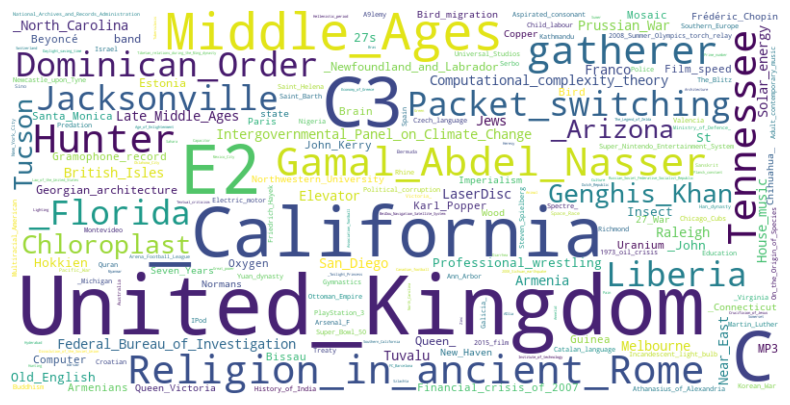

In [19]:
from wordcloud import WordCloud
# Generate a word cloud of titles to see the broad range of topics covered in the dataset
text = ' '.join(squad_df_train['title'].unique())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
train_data_T5Format.head(1)

,input_text,target_text
0,"question: What troops were uniquely successful in English service? context: One of the major developments in the military sphere during the Late Middle Ages was the increased use of infantry and light cavalry. The English also employed longbowmen, but other countries were unable to create similar forces with the same success. Armour continued to advance, spurred by the increasing power of crossbows, and plate armour was developed to protect soldiers from crossbows as well as the hand-held guns that were developed. Pole arms reached new prominence with the development of the Flemish and Swiss infantry armed with pikes and other long spears.",longbowmen


## Tokenization

Each dataset entry, consisting of context paragraphs along with associated questions and answers, is processed using the T5 tokenizer to convert the text into a format that is understandable by the model. Based on the exploratory data analysis (EDA) conducted prior to the training, I determined optimal settings for the maximum token lengths for inputs and outputs. The maximum length for the input to the model is set to 512 tokens. Similarly, the maximum length for the output text, which consists of the answers, is set to 30 tokens.

In [21]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, EarlyStoppingCallback

# Initialize the T5 tokenizer

T5MODEL_CHKPT = "t5-small"
# Load pre-trained T5 tokenizer base model
tokenizer = T5Tokenizer.from_pretrained(T5MODEL_CHKPT)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [22]:
# Function to tokenize dataframe
def tokenize_data(row):
    model_inputs = tokenizer(row['input_text'], padding="max_length", truncation=True, max_length=512)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(row['target_text'], padding="max_length", truncation=True, max_length=30)

    return {
        'input_ids': model_inputs.input_ids,
        'attention_mask': model_inputs.attention_mask,
        'labels': labels.input_ids
    }

In [23]:
# Get tokenized data
train_data_tokenized = train_data_T5Format.progress_apply(tokenize_data, axis=1)
validation_data_tokenized = validation_data_T5Format.progress_apply(tokenize_data, axis=1)

  0%|          | 0/88330 [00:00<?, ?it/s]C:\Users\bplse\anaconda3\envs\AAI_520_CUDA\Lib\site-packages\transformers\tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
100%|██████████| 9815/9815 [00:13<00:00, 723.06it/s]


## Model Selection and Training

I have chosen the T5 pre-trained base model for fine-tuning due to its balance between performance and computational efficiency. The training process is done through TrainingArguments which specify various parameters that control the training behavior. The Trainer is then initialized with the model, training arguments, and datasets. It handles the training loop, evaluation, and saving of the model.

In [24]:
# Load pre-trained T5 base model
model = T5ForConditionalGeneration.from_pretrained(T5MODEL_CHKPT)

In [25]:
logging_dir='./logs'
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # number of training epochs
    learning_rate=5e-5,              # learning rate
    eval_steps= 500,                 # Perform evaluation every 500 steps
    per_device_train_batch_size=16,   # batch size for training
    per_device_eval_batch_size=16,    # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=logging_dir,            # directory for storing logs
    logging_steps=10,                # log metrics every 10 steps
    evaluation_strategy="steps",     # Evaluate every `logging_steps` if set
    load_best_model_at_end=True,     # Load best model at end of training for evaluation
    metric_for_best_model="loss",    # use loss to determine the best model
    fp16=True                        # Mixed Precision Training
    #report_to="tensorboard"         # Enable logging to TensorBoard
)

C:\Users\bplse\anaconda3\envs\AAI_520_CUDA\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
#%load_ext tensorboard

In [27]:
# Start tensorboard
#%tensorboard --logdir="./logs"

In [28]:
# Initialize the Trainer
trainer = Trainer(
    model=model,                                                   # Initialized model
    args=training_args,                                            # training arguments
    train_dataset=train_data_tokenized,                            # training dataset
    eval_dataset=validation_data_tokenized,                        # validation dataset
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]  # adding early stopping
)

C:\Users\bplse\anaconda3\envs\AAI_520_CUDA\Lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [29]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss
500,0.093500,0.062971
1000,0.082700,0.061362
1500,0.078700,0.061724
2000,0.065000,0.061669
2500,0.084400,0.060297
3000,0.086600,0.059197
3500,0.103400,0.059893
4000,0.082600,0.059469
4500,0.074300,0.058680
5000,0.067000,0.059461


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=11042, training_loss=0.19288355190481662, metrics={'train_runtime': 5451.1098, 'train_samples_per_second': 32.408, 'train_steps_per_second': 2.026, 'total_flos': 2.390948264804352e+16, 'train_loss': 0.19288355190481662, 'epoch': 2.0})

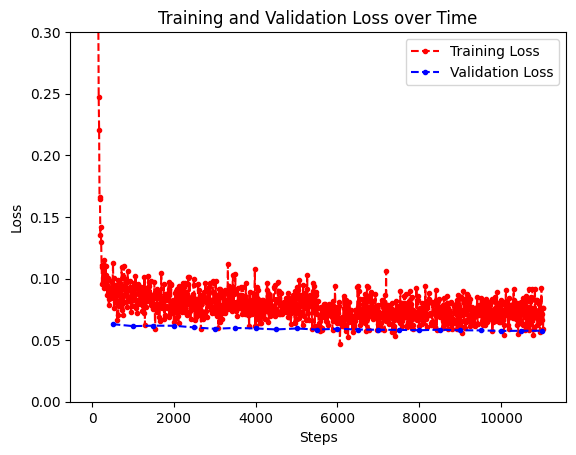

In [30]:
# Get the log history using the trainer object
training_logs = trainer.state.log_history

# Extracting training loss and validation loss along with steps
train_loss_values = [log["loss"] for log in training_logs if "loss" in log and "eval_loss" not in log]
eval_loss_values = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
train_steps = [log["step"] for log in training_logs if "loss" in log and "eval_loss" not in log]
eval_steps = [log["step"] for log in training_logs if "eval_loss" in log]

# Plotting the training and validation loss
plt.plot(train_steps, train_loss_values, label="Training Loss", color='red',marker='.', linestyle='--')
plt.plot(eval_steps, eval_loss_values, label="Validation Loss", color='blue',marker='.',linestyle='--')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.ylim(0,0.3)
plt.title("Training and Validation Loss over Time")
plt.legend()
plt.show()

## Model testing:

### Use-case: Answer the user query provided we have the context of the question.

In [31]:
def generate_answer(context, question):
    # Ensure the model and tokenizer are on the same device
    model.to(device)

    # Format the input text
    input_text = f"question: {question} context: {context}"

    # Encode the input text and move tensors to the same device as the model
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

    # Generate output tensors with controlled parameters
    outputs = model.generate(
        input_ids,
        max_length=20,  # Adjust based on expected answer length
        num_beams=5,  # Use beam search for more focused outputs
        do_sample=True,
        no_repeat_ngram_size=2,  # Prevent repeating the same n-grams
        early_stopping=True,  # Stop as soon as num_beams sentences are fully generated
        temperature=0.1  # Lower for less randomness, closer to 0 makes it more deterministic
    )

    # Decode and return the answer
    decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_text

In [32]:
context = "Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend \"Venite Ad Me Omnes\". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary"
question = "To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?"
print(generate_answer(context, question))

Saint Bernadette Soubirous


In [33]:
train_data_T5Format.shape

(88330, 2)

## Context retrival

A key component of my question-answering chatbot involves the retrieval of relevant context from the SQuAD dataset to effectively answer user queries. For this purpose, I utilize a context retrieval system that leverages Sentence Transformers and FAISS to efficiently identify the most semantically relevant contexts for user queries. Context paragraphs are first encoded into dense vector embeddings using the 'all-MiniLM-L6-v2' Sentence Transformer, capturing the semantic nuances of the text. These embeddings are then indexed using FAISS  (Facebook AI Similarity Search), an optimized library for fast high-dimensional data retrieval. This setup allows for rapid and precise retrieval of context paragraphs that are most similar to the vector representation of a user's question.

In [34]:
from sentence_transformers import SentenceTransformer

model_st = SentenceTransformer('all-MiniLM-L6-v2')
# Concatenate vertically train and validation dataset to create a combined dataframe used for context retrival and indexing
df_combined = pd.concat([squad_df_train["context"], squad_df_validation["context"]], axis=0)
df_combined = df_combined.reset_index(drop=True)

C:\Users\bplse\anaconda3\envs\AAI_520_CUDA\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
type(df_combined)

pandas.core.series.Series

In [36]:
# Encode contexts
unique_df_combined = df_combined.unique()
context_embeddings = model_st.encode(unique_df_combined.tolist(), convert_to_tensor=True)
context_embeddings = context_embeddings.cpu().detach().numpy()  # Move to numpy for FAISS

C:\Users\bplse\anaconda3\envs\AAI_520_CUDA\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [37]:
len(unique_df_combined)

20953

In [38]:
import faiss

# Create a FAISS index
index = faiss.IndexFlatL2(context_embeddings.shape[1])
# Add the vectors to the index
index.add(context_embeddings)


In [39]:
# Function to retrieve context. Select the top 3 contexts and combine them to single context.
def retrieve_context(question, k=3):
    context_k = []
   
    question_embedding = model_st.encode([question])
    distances, indices = index.search(question_embedding, k)   
    
    for i, idx in enumerate(indices[0]):
        if distances[0][i] < 1:
            context_k.append([unique_df_combined[idx]])
           
    # Flatten the list of context_k
    flattened_context = [context for contexts in context_k for context in contexts]   
    
    # Concatenate all sentences into a single string, separated by a space
    single_context = "".join(flattened_context)

    return single_context


In [40]:
'''q = "What is famous in Notre Dame?"
ck = retrieve_context(q)
print(ck)'''

'q = "What is famous in Notre Dame?"\nck = retrieve_context(q)\nprint(ck)'

## Model testing:
### Use-case: Answer the user query.¶

#### Process:
Retrieve the context based on the query, and provide both the retrieved context and the query to the model to answer the query."


### Unit test

In [41]:
# List of question
question = ["Which sport Notre Dame is known for?", "What is famous in Notre Dame?", "what is meaning of  Notre Dame in French?", "What is box cooker?", "who was Vincenzo Galilei?", "what was Space Race?"]

for q in question:
    print("\nQuestion:",q)
    retrieved_contexts = retrieve_context(q)  
    
    if retrieved_contexts == "":
      print("\nAnswer: Sorry, I don't have enough information to answer this question.")
    else:      
      print("\nRetrieved Context:",retrieved_contexts)
      # Generate answer using the questiona and its corresponding retrieved context
      print("\nAnswer: *****", generate_answer(retrieved_contexts, q), " *****")



Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors



Question: Which sport Notre Dame is known for?

Retrieved Context: The Notre Dame football team has a long history, first beginning when the Michigan Wolverines football team brought football to Notre Dame in 1887 and played against a group of students. In the long history since then, 13 Fighting Irish teams have won consensus national championships (although the university only claims 11), along with another nine teams being named national champion by at least one source. Additionally, the program has the most members in the College Football Hall of Fame, is tied with Ohio State University with the most Heisman Trophies won, and have the highest winning percentage in NCAA history. With the long history, Notre Dame has accumulated many rivals, and its annual game against USC for the Jeweled Shillelagh has been named by some as one of the most important in college football and is often called the greatest intersectional rivalry in college football in the country.Notre Dame rose to nati

In [57]:
#model.save_pretrained("/content/drive/MyDrive/USD/AAI-520-NLPGenAI/FinalProject/model_checkpointsT5_Full_Dataset")
#tokenizer.save_pretrained("/content/drive/MyDrive/USD/AAI-520-NLPGenAI/FinalProject/model_checkpointsT5_Full_Dataset")


('./model_checkpointsT5_Full_Dataset\\tokenizer_config.json',
 './model_checkpointsT5_Full_Dataset\\special_tokens_map.json',
 './model_checkpointsT5_Full_Dataset\\spiece.model',
 './model_checkpointsT5_Full_Dataset\\added_tokens.json')

## Evaluation

To evaluate the effectiveness and accuracy of the fine-tuned model, I use evaluation metrics such as the exact match (EM) and F1 score. These metrics are calculated using the validation dataset, which was not involved in the training phase to ensure an unbiased evaluation of the model's performance. The exact match score indicates how often the chatbot's responses exactly match the expected answers, while the F1 score provides insights into the model's overall accuracy by considering both the precision and recall of the answers. Additionally, using cosine similarity from Sentence-Transformer and BERT embeddings, I gauged how closely the chatbot's answers resembled the true answers semantically.

### Evaluate cosine similarity using Sentence Transformer Encoder

In [43]:
from sentence_transformers import util

def evaluate_model_CosineSimilarity(dataframe, model):
    results = {
        "question": [],
        "prediction": [],
        "truth": [],
        "similarity": []
    }
    cosine_scores = []
    model.eval()

    #for idx, row in dataframe.iterrows():
    for idx, row in tqdm(dataframe.iterrows(), desc="Evaluation"):
      retrieved_contexts = retrieve_context(row['question'])
      predicted_answer = generate_answer(retrieved_contexts, row['question'])
     
      # Storing results
      results["question"].append(row['question'])
      results["prediction"].append(predicted_answer)
      results["truth"].append(row['answer'])
      # Encode sentences and compute similarities
      embeddings1 = model_st.encode(predicted_answer, convert_to_tensor=True)
      embeddings2 = model_st.encode(row['answer'], convert_to_tensor=True)

      # Compute cosine similarities
      cosine_score = util.pytorch_cos_sim(embeddings1, embeddings2)
      results["similarity"].append(cosine_score.item())
      cosine_scores.append(cosine_score.item())

    mean_score = np.mean(cosine_scores)
    print(np.mean(mean_score))
    return mean_score, results


# Evaluate
cosine_scores, results = evaluate_model_CosineSimilarity(squad_df_validation, model)

Evaluation: 9815it [1:01:02,  2.68it/s]

0.6790036669718335


In [44]:
print(pd.DataFrame(results).sample(n=10, random_state=42, ignore_index=True))

                                                                             question  \
0                        Courts in commonwealth nations are often influenced by what?   
1                 What document was meant to resolve lingering issues of colonialism?   
2                                                              What shape is The Hub?   
3                                        What land was included in the kingdom of Ba?   
4  What two-word term does Scotland use to describe their technological universities?   
5                          In what century was One Thousand and One Nights completed?   
6                                         When was the Rebellion of the Seven States?   
7                                                       What is Tucson's ABC station?   
8           When did Hack Wilson set a record of 56 home-runs and 190 runs-batted-in?   
9                      The Byzantine had control over most of Greece in what century?   

             predict

In [45]:
st_similarity_df = pd.DataFrame(results)
st_similarity_df["similarity"].describe()

count    9815.000000
mean        0.679004
std         0.346923
min        -0.119611
25%         0.321124
50%         0.836538
75%         1.000000
max         1.000000
Name: similarity, dtype: float64

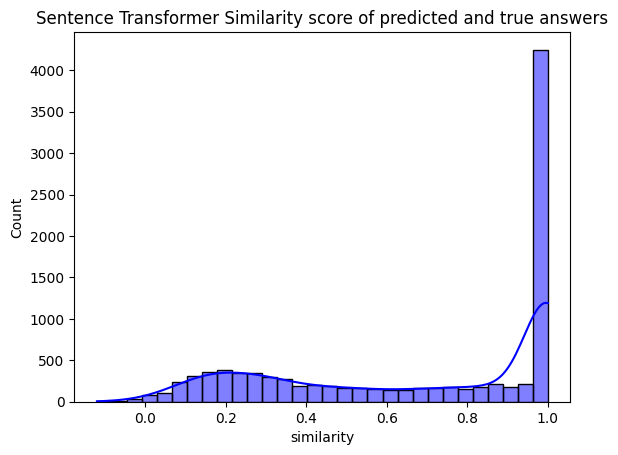

In [46]:
# Plot Similarty score results
plt.figure()
sns.histplot(st_similarity_df["similarity"], kde=True, color="blue", bins=30)
plt.title('Sentence Transformer Similarity score of predicted and true answers')
plt.show()

### Evaluate cosine similarity using BERT Encoder

In [47]:
from transformers import AutoTokenizer, AutoModel
# Load tokenizer and model
tokenizer_bert = AutoTokenizer.from_pretrained('bert-base-uncased')
model_bert = AutoModel.from_pretrained('bert-base-uncased')

 # Function to encode text to get embeddings
def get_embedding(text):
    tokens = tokenizer_bert(text, return_tensors='pt', padding=True, truncation=True)
    outputs = model_bert(**tokens)
    # Use mean of last layer hidden states as the sentence embedding
    embeddings = outputs.last_hidden_state.mean(1)
    return embeddings


def evaluate_model_CosineSimilarityBERT(dataframe, model):
    # Store evaluation results of Bert cosine similarity
    similarity_results = {
        "question": [],
        "prediction": [],
        "truth": [],
        "similarity": []
    }

    cosine_scores = []
    model.eval()

    for idx, row in tqdm(dataframe.iterrows(), desc="Evaluation"):
      retrieved_contexts = retrieve_context(row['question'])
      predicted_answer = generate_answer(retrieved_contexts, row['question'])
      #print("predicted_answer : " ,predicted_answer)
      #print("row['answer'] : " ,row['answer'])
        

      # Storing results
      similarity_results["question"].append(row['question'])
      similarity_results["prediction"].append(predicted_answer)
      similarity_results["truth"].append(row['answer'])

      # Compute embeddings
      embed1 = get_embedding(predicted_answer)
      embed2 = get_embedding(row['answer'])

      # Compute cosine similarity as a measure of semantic similarity
      cosine_sim = torch.nn.functional.cosine_similarity(embed1, embed2)
      similarity_results["similarity"].append(cosine_sim.item())
      cosine_scores.append(cosine_sim.item())

    mean_score = np.mean(cosine_scores)
    print("\nBERT Cosine Similarity:", mean_score)
    return mean_score, similarity_results

# Evaluate
cosine_scores_bert, similarity_results = evaluate_model_CosineSimilarityBERT(squad_df_validation, model)

C:\Users\bplse\anaconda3\envs\AAI_520_CUDA\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Evaluation: 9815it [12:56:38,  4.75s/it]  


BERT Cosine Similarity: 0.800245477992451


In [48]:
print(pd.DataFrame(similarity_results).sample(n=10, random_state=42, ignore_index=True))

                                                                             question  \
0                        Courts in commonwealth nations are often influenced by what?   
1                 What document was meant to resolve lingering issues of colonialism?   
2                                                              What shape is The Hub?   
3                                        What land was included in the kingdom of Ba?   
4  What two-word term does Scotland use to describe their technological universities?   
5                          In what century was One Thousand and One Nights completed?   
6                                         When was the Rebellion of the Seven States?   
7                                                       What is Tucson's ABC station?   
8           When did Hack Wilson set a record of 56 home-runs and 190 runs-batted-in?   
9                      The Byzantine had control over most of Greece in what century?   

             predict

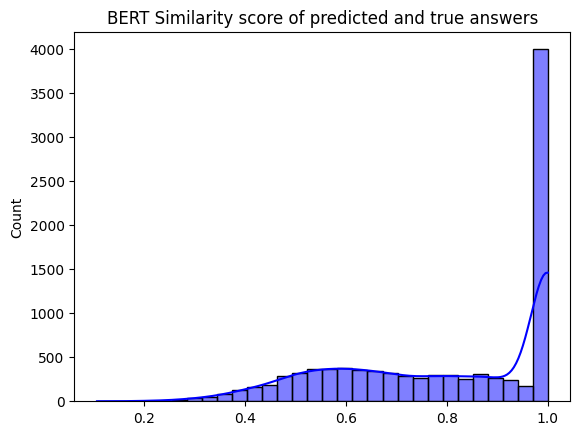

In [49]:
# Plot Similarty score results
plt.figure()
sns.histplot(similarity_results["similarity"], kde=True, color="blue", bins=30)
plt.title('BERT Similarity score of predicted and true answers')
plt.show()

In [50]:
def is_number(input_string):
    if input_string.isdigit():
        return True
    # Regular expression to match numeric patterns (e.g., 24, 2.4)
    if re.match(r'^\d+(\.\d+)?$', input_string):
        return True
    return False



In [51]:
from word2number import w2n

def convert_word_to_number(word):
    try:
        return w2n.word_to_num(word)
    except ValueError as e:
        #print(f"Error: {e}")
        return "----"

In [52]:
import collections

def compute_exact_match(prediction, truth):
   # Check for number matching (word and numeric)
    if is_number(truth) == True:
        if is_number(prediction) == False:
            prediction = str(convert_word_to_number(prediction))

    return int(prediction.strip().lower() == truth.strip().lower())

def compute_f1(prediction, truth):

    # Check for number matching (word and numeric)
    if is_number(truth) == True:
        if is_number(prediction) == False:
            prediction = str(convert_word_to_number(prediction))
    pred_tokens = prediction.lower().split()
    truth_tokens = truth.lower().split()

    common_tokens = collections.Counter(pred_tokens) & collections.Counter(truth_tokens)
    num_same = sum(common_tokens.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_tokens)
    recall = 1.0 * num_same / len(truth_tokens)
    return (2 * precision * recall) / (precision + recall)


In [53]:
def evaluate_model_EM_F1(dataframe, model, tokenizer):
    results = {
        "prediction": [],
        "truth": [],
        "exact_match": [],
        "f1_score": []
    }
    model.eval()

    #for idx, row in dataframe.iterrows():
    for idx, row in tqdm(dataframe.iterrows(), desc="Evaluation"):
      retrieved_contexts = retrieve_context(row['question'])
      predicted_answer = generate_answer(retrieved_contexts, row['question'])
      if idx%1000 == 0:
        print("\nTesting EM/F1----------------------------------------------------------------------")
        print("\nQuestion: " ,row['question'])
        print("Retrieved_Contexts : ", retrieved_contexts)
        print("\nPredicted_Answer : " ,predicted_answer, ", true_answer : " ,row['answer'])
        
      em = compute_exact_match(predicted_answer, row['answer'])
      f1 = compute_f1(predicted_answer, row['answer'])

      # Storing results
      results["prediction"].append(predicted_answer)
      results["truth"].append(row['answer'])
      results["exact_match"].append(em)
      results["f1_score"].append(f1)

    # Convert results to DataFrame for better visualization and analysis
    results_df = pd.DataFrame(results)
    print(f"\n\nAverage Exact Match Score: {results_df['exact_match'].mean()}")
    print(f"Average F1 Score: {results_df['f1_score'].mean()}")
    return results_df


# Evaluate
evaluation_results = evaluate_model_EM_F1(squad_df_validation, model, tokenizer)


Evaluation: 1it [00:00,  2.69it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  What is the most common test subjects for studying of the brain?
Retrieved_Contexts :  The field of neuroscience encompasses all approaches that seek to understand the brain and the rest of the nervous system. Psychology seeks to understand mind and behavior, and neurology is the medical discipline that diagnoses and treats diseases of the nervous system. The brain is also the most important organ studied in psychiatry, the branch of medicine that works to study, prevent, and treat mental disorders. Cognitive science seeks to unify neuroscience and psychology with other fields that concern themselves with the brain, such as computer science (artificial intelligence and similar fields) and philosophy.The simplest way to gain information about brain anatomy is by visual inspection, but many more sophisticated techniques have been developed. Brain tissue in its natural state is too soft to wor

Evaluation: 1001it [05:30,  2.54it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  What type of herbicide selectively kills broad leef weeds?
Retrieved_Contexts :  The following sulfonylureas have been commercialized for weed control: amidosulfuron, azimsulfuron, bensulfuron-methyl, chlorimuron-ethyl, ethoxysulfuron, flazasulfuron, flupyrsulfuron-methyl-sodium, halosulfuron-methyl, imazosulfuron, nicosulfuron, oxasulfuron, primisulfuron-methyl, pyrazosulfuron-ethyl, rimsulfuron, sulfometuron-methyl Sulfosulfuron, terbacil, bispyribac-sodium, cyclosulfamuron, and pyrithiobac-sodium. Nicosulfuron, triflusulfuron methyl, and chlorsulfuron are broad-spectrum herbicides that kill plants by inhibiting the enzyme acetolactate synthase. In the 1960s, more than 1 kg/ha (0.89 lb/acre) crop protection chemical was typically applied, while sulfonylureates allow as little as 1% as much material to achieve the same effect.In general, a pesticide is a chemical or biological agent (such 

Evaluation: 2001it [10:56,  3.33it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  What year were over 2 million children employed in the US?
Retrieved_Contexts :  In 1910, over 2 million children in the same age group were employed in the United States. This included children who rolled cigarettes, engaged in factory work, worked as bobbin doffers in textile mills, worked in coal mines and were employed in canneries. Lewis Hine's photographs of child labourers in the 1910s powerfully evoked the plight of working children in the American south. Hines took these photographs between 1908 and 1917 as the staff photographer for the National Child Labor Committee.Home-based manufacturing operations were active year round. Families willingly deployed their children in these income generating home enterprises. In many cases, men worked from home. In France, over 58 percent of garment workers operated out of their homes; in Germany, the number of full-time home operations nearly 

Evaluation: 3001it [16:29,  2.99it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  How many varieties of seedless grapes are there? 
Retrieved_Contexts :  There are several sources of the seedlessness trait, and essentially all commercial cultivators get it from one of three sources: Thompson Seedless, Russian Seedless, and Black Monukka, all being cultivars of Vitis vinifera. There are currently more than a dozen varieties of seedless grapes. Several, such as Einset Seedless, Benjamin Gunnels's Prime seedless grapes, Reliance, and Venus, have been specifically cultivated for hardiness and quality in the relatively cold climates of northeastern United States and southern Ontario.Grape juice is obtained from crushing and blending grapes into a liquid. The juice is often sold in stores or fermented and made into wine, brandy, or vinegar. Grape juice that has been pasteurized, removing any naturally occurring yeast, will not ferment if kept sterile, and thus contains no alco

Evaluation: 4001it [22:03,  2.88it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  What year is the earliest reference to 'classical music'?
Retrieved_Contexts :  The term "classical music" did not appear until the early 19th century, in an attempt to distinctly canonize the period from Johann Sebastian Bach to Beethoven as a golden age. The earliest reference to "classical music" recorded by the Oxford English Dictionary is from about 1836.The term "classical music" has two meanings: the broader meaning includes all Western art music from the Medieval era to today, and the specific meaning refers to the music from the 1750s to the early 1830s—the era of Mozart and Haydn. This section is about the more specific meaning.Classical music is art music produced or rooted in the traditions of Western music, including both liturgical (religious) and secular music. While a similar term is also used to refer to the period from 1750 to 1820 (the Classical period), this article is a

Evaluation: 5001it [27:42,  3.17it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  How many native speakers are in each apartment building in the Foreign Language Student Residence program?
Retrieved_Contexts :  A few special additions enhance the language-learning experience. For example, BYU's International Cinema, featuring films in several languages, is the largest and longest-running university-run foreign film program in the country. As already noted, BYU also offers an intensive foreign language living experience, the Foreign Language Student Residence. This is an on-campus apartment complex where students commit to speak only their chosen foreign language while in their apartments. Each apartment has at least one native speaker to ensure correct language usage.Over three quarters of the student body has some proficiency in a second language (numbering 107 languages in total). This is partially due to the fact that 45 percent of the student body at BYU has been mis

Evaluation: 6001it [33:13,  3.87it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  When were the next elections?
Retrieved_Contexts :  The country was controlled by a revolutionary council until 1984. The first multi-party elections were held in 1994. An army uprising in May 1998 led to the Guinea-Bissau Civil War and the president's ousting in June 1999. Elections were held again in 2000, and Kumba Ialá was elected president.The election held in 1988 saw the advent of the mlolongo (queuing) system, where voters were supposed to line up behind their favoured candidates instead of a secret ballot. This was seen as the climax of a very undemocratic regime and it led to widespread agitation for constitutional reform. Several contentious clauses, including one that allowed for only one political party were changed in the following years. In democratic, multiparty elections in 1992 and 1997, Daniel arap Moi won re-election.

Predicted_Answer :  2000 , true_answer :  May 2007


Evaluation: 7001it [38:41,  2.95it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  The culmination of the Russo-Turkish war granted what to the citizens of Ottoman controlled Provinces in Moldavia?
Retrieved_Contexts :  In 1768 Russian-backed Ukrainian Haidamaks, pursuing Polish confederates, entered Balta, an Ottoman-controlled town on the border of Bessarabia in Ukraine, and massacred its citizens and burned the town to the ground. This action provoked the Ottoman Empire into the Russo-Turkish War of 1768–1774. The Treaty of Küçük Kaynarca of 1774 ended the war and provided freedom to worship for the Christian citizens of the Ottoman-controlled provinces of Wallachia and Moldavia. By the late 18th century, a number of defeats in several wars with Russia led some people in the Ottoman Empire to conclude that the reforms of Peter the Great had given the Russians an edge, and the Ottomans would have to keep up with Western technology in order to avoid further defeats.Sulei

Evaluation: 8002it [44:14,  3.65it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  Who elected Tito president in 1971?
Retrieved_Contexts :  In 1971, Tito was re-elected as President of Yugoslavia by the Federal Assembly for the sixth time. In his speech before the Federal Assembly he introduced 20 sweeping constitutional amendments that would provide an updated framework on which the country would be based. The amendments provided for a collective presidency, a 22-member body consisting of elected representatives from six republics and two autonomous provinces. The body would have a single chairman of the presidency and chairmanship would rotate among six republics. When the Federal Assembly fails to agree on legislation, the collective presidency would have the power to rule by decree. Amendments also provided for stronger cabinet with considerable power to initiate and pursue legislature independently from the Communist Party. Džemal Bijedić was chosen as the Premier. 

Evaluation: 9001it [49:53,  2.75it/s]


Testing EM/F1----------------------------------------------------------------------

Question:  Approximately how many British oil paintings does the museum have?
Retrieved_Contexts :  The collection includes about 1130 British and 650 European oil paintings, 6800 British watercolours, pastels and 2000 miniatures, for which the museum holds the national collection. Also on loan to the museum, from Her Majesty the Queen Elizabeth II, are the Raphael Cartoons: the seven surviving (there were ten) full scale designs for tapestries in the Sistine Chapel, of the lives of Peter and Paul from the Gospels and the Acts of the Apostles. There is also on display a fresco by Pietro Perugino dated 1522 from the church of Castello at Fontignano (Perugia) and is amongst the painter's last works. One of the largest objects in the collection is the Spanish tempera on wood, 670 x 486 cm, retable of St George, c. 1400, consisting of numerous scenes and painted by Andrés Marzal De Sax in Valencia.London 

Evaluation: 9815it [54:23,  3.01it/s]



Average Exact Match Score: 0.4022414671421294
Average F1 Score: 0.5331048647585188


In [54]:
print(evaluation_results.sample(n=10, random_state=42, ignore_index=True))

             prediction  \
0  each other's rulings   
1              document   
2               The Hub   
3             Chongqing   
4             "Varsity"   
5                  14th   
6                154 BC   
7                KGUN 9   
8                  1930   
9          14th century   

                                                                                    truth  \
0                                                                 by each other's rulings   
1                                                                        Final Communique   
2                                                                                 bow-tie   
3  Chongqing and the land in eastern Sichuan along the Yangtze and some tributary streams   
4                                                                    Central Institutions   
5                                                                            14th century   
6                                                  

## User Interface

In [55]:
# define global retrieved_contexts
retrieved_contexts = ""

def on_button_clicked(b):
    user_query = input_textarea.value
    if not user_query.endswith('?'):
        user_query += '?'
      
    with answer_output:        
        global retrieved_contexts
        if retrieved_contexts == "":
            retrieved_contexts = retrieve_context(user_query)           
            print("Retrieved Context:", retrieved_contexts)   
        else:
            #  Check if question is in current context by checking it cosine similarity
            embeddings1 = model_st.encode(retrieved_contexts, convert_to_tensor=True)
            embeddings2 = model_st.encode(user_query, convert_to_tensor=True)
        
            # Compute cosine similarities as a measure of semantic similarity
            cosine_score = util.pytorch_cos_sim(embeddings1, embeddings2)
            #print("\n Question Context match : " , cosine_score)            
            if cosine_score < 0.3:
                print(f"\nYour question was: {user_query}")
                print("\nQuestion is out of context. Please PRESS [Clear Context] button to clear the old context!!!")
                return             
        answer = generate_answer(retrieved_contexts, user_query) 
        print(f"\nYour question was: {user_query}") 
        print(f"The answer is:", answer)
        
def on_button_clicked_clear(b):
    global retrieved_contexts
    with question_output:
        question_output.clear_output()       
    
    with answer_output:
        answer_output.clear_output()       
        retrieved_contexts = ""    


In [56]:
import ipywidgets as widgets
from IPython.display import display

# Output widget for displaying questions and answers
question_output = widgets.Output()
answer_output = widgets.Output()

# Textarea for input
input_textarea = widgets.Textarea(
    value='',
    placeholder='Type your question here...',
    description='Question:',
    disabled=False,
    rows=2,
    layout=widgets.Layout(width='100%')
)

# Button for submitting the question
button_send = widgets.Button(
    description='Get Answer',
    disabled=False,
    button_style='info',
    tooltip='Click to get an answer',
    icon='check' 
)
# Event handler for the button
button_send.on_click(on_button_clicked)

# Button for clear context
button_clear = widgets.Button(
    description='Clear Context',
    disabled=False,
    button_style='info',
    tooltip='Clear the current context',
    icon='check' 
)
# Event handler for the button
button_clear.on_click(on_button_clicked_clear)

# Display the components
display(input_textarea, button_send, button_clear, question_output, answer_output)

Textarea(value='', description='Question:', layout=Layout(width='100%'), placeholder='Type your question here.…

Button(button_style='info', description='Get Answer', icon='check', style=ButtonStyle(), tooltip='Click to get…

Button(button_style='info', description='Clear Context', icon='check', style=ButtonStyle(), tooltip='Clear the…

Output()

Output()

## Challenges
- During the evaluation phase of the project, a specific challenge arose concerning the model's output format, particularly in cases where the model would produce a word representation of a number (e.g., "five") while the correct answer was in numeric form (e.g., "5"). This mismatch led to failures in the exact match metric, which requires direct textual agreement between the predicted and actual answers. To address this, I incorporated the word2number library to convert word representations of numbers in the model's output into their numeric equivalents.
- The GPU was running out of memory, and although the CPU managed to handle the workload, it was significantly slower. Additionally, training on Google Colab also took too long. To address these issues, I switched to the t5-small model, reduced the batch size, and decreased the number of epochs. These adjustments allowed me to complete the training on my local GPU during unit testing in a relatively short time and also expedited the process on Colab.  
- Fine-tuning the t5-small model struggled with sentences requiring longer attention spans, leading to diminished effectiveness in answer accuracy.

## Conclusion

The project successfully demonstrated the capability of a generative chatbot to answer questions accurately using a combination of advanced NLP techniques and deep learning. The integration of Sentence Transformers and FAISS for context retrieval enhanced the relevance of the responses generated by the T5 model. The high scores on standardized metrics suggest that the model is well-tuned for the question answering task on structured data like SQuAD.


## Future Work

- Expand the Dataset: Incorporating additional datasets or newer versions of SQuAD could further improve the robustness and comprehensiveness of the chatbot.
- Multilingual Support: Extending the model to support multiple languages could increase its applicability.
- Real-time Learning: Implementing functionality for the model to learn from new questions and answers dynamically could make the chatbot more adaptive and intelligent over time.
- Web access implementation: Setting up web access for the chatbot to facilitate question answering.